In [1]:
from utils import *

# libraries for Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

# libraries for features selectiona
# ANOVA F-test
from sklearn.feature_selection import f_classif
from sklearn import datasets

# library for standardize features
from sklearn.preprocessing import StandardScaler

# libraries for epsilon parameter
from sklearn.neighbors import NearestNeighbors

# libraries for Clustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

# libraries for Adjusted Rand Index
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# libraries for general utilities
import numpy as np 
from matplotlib import pyplot as plt

# global variables from work specifications
SEED = 42
set_seed(SEED)
NUMBER_FEATURES = 6
NEIGHBOURS = 5

In [2]:
def findEpsParams(features):
    
    neigh = NearestNeighbors(n_neighbors=NEIGHBOURS)
    nbrs = neigh.fit(features)
    distances, indices = nbrs.kneighbors(features)
    
    print(distances)

    distances = np.sort(distances, axis=0)[:,NEIGHBOURS-1]
    plt.plot(distances)
    plt.show()

    return 0.3

In [3]:
##
## DATASET LOADING
##

# create the loader class and load dataset and labels
loader = Loader().load()

# get dataset, labels, and dataset splitted by classes
dataset = loader.getDataset()
labels = loader.getLabels()
class_split_dataset = loader.getClassSplitDataset()



In [4]:
dataset.shape

(563, 2500)

In [5]:
##
## FEATURES CREATION
##

# extract 6 features wirh PCA
pca = PCA(n_components=NUMBER_FEATURES)
pca_dataset_embedded = pca.fit_transform(dataset)

# extract 6 features wirh t-sne
tsne = TSNE(n_components=NUMBER_FEATURES, method='exact')
tsne_dataset_embedded = tsne.fit_transform(dataset)

# extract 6 features wirh isomap
isomap = Isomap(n_components=NUMBER_FEATURES)
isomap_dataset_embedded = isomap.fit_transform(dataset)

# features concatenate (6,6,6) = 18 features
features = np.concatenate((pca_dataset_embedded,tsne_dataset_embedded, isomap_dataset_embedded), axis=1)

In [6]:
pca_dataset_embedded.shape

(563, 6)

In [7]:
features[1:5,:]

array([[-1.82143846e+03, -6.63846333e+02,  7.06981213e+02,
         2.37248955e+02,  1.60360027e+02,  5.28306558e+02,
         7.72390461e+00, -2.49152708e+00,  6.92456770e+00,
        -1.39344387e+01,  2.19988136e+01, -3.38421202e+00,
        -5.85896495e+03, -1.55769827e+02,  4.57229126e+02,
         5.83601092e+02,  5.40286541e+02,  2.36721532e+03],
       [ 1.03153662e+03,  5.36641403e+02,  6.57672061e+02,
         1.33847115e+03, -3.38104282e+02, -6.36852334e+02,
         3.74526834e+00, -8.44711399e+00, -4.67220879e+00,
         4.46410942e+00, -1.91819363e+01, -3.70564532e+00,
         1.00839856e+03,  3.53220828e+03,  3.38657939e+02,
         2.94287615e+03, -1.45621664e+03,  7.69372197e+00],
       [-1.03628366e+03, -6.75668234e+02, -4.66837833e+02,
        -1.87282961e+02,  1.15935676e+02,  1.15187160e+02,
        -6.67192173e+00, -3.88297009e+00,  1.18621445e+01,
         2.56959867e+00,  4.08542871e+00,  5.07367373e+00,
        -1.99202934e+03, -1.85770786e+03,  8.14116373e

In [8]:
# standardization
scaler = StandardScaler()
features_std = scaler.fit_transform(features)

In [9]:
print(features_std.shape)
print(labels.shape)

(563, 18)
(563, 2)


In [10]:
##
## FEATURES EXTRACTION
##

# selection with ANOVA F-test
f,prob = f_classif(features_std, labels[:,1])
print(f)
print(prob)

[12.79637841 19.24821341 32.71839925  0.63172337  3.43336257  1.89895973
  3.52326974  1.99106122  0.88030932  0.3459137   5.20874744  3.13436264
 14.04786286 41.31820477  5.37225413  5.7198292   6.81730345  1.3927433 ]
[4.25350548e-08 6.86097946e-12 1.70256366e-19 5.94769523e-01
 1.68207626e-02 1.28643767e-01 1.48939918e-02 1.14227316e-01
 4.51028922e-01 7.92129373e-01 1.48683101e-03 2.51736599e-02
 7.69520113e-09 3.96454630e-24 1.18712751e-03 7.35260521e-04
 1.61480141e-04 2.44046422e-01]


[[0.         2.31755361 2.37708108 2.46729618 2.58478541]
 [0.         1.03850151 1.60137331 1.69396241 1.70009658]
 [0.         2.98961102 3.10353518 3.27869244 3.43560942]
 ...
 [0.         1.62966766 2.06761589 2.14452765 2.29181691]
 [0.         1.66479604 1.89621405 2.25945712 2.59020299]
 [0.         1.33776795 1.44364968 1.63795172 1.68504467]]


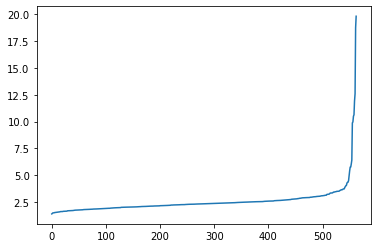

In [11]:
##
##  CLUSTERING
##

# selecting manually the epsilon params for DBSCAN
eps = findEpsParams(features_std)

In [12]:
# clustering with DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=NEIGHBOURS)
dbscan_labels = dbscan.fit_predict(features_std)

# clustering with K-MEANS
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(features_std)

In [14]:
import utilities as uti

vlarray=uti.take_valid_labels(labels)

featu=features_std

val_int, val_ext= uti.kmeans_all_results(featu,10,vlarray)

In [15]:
val_int


[[2, 0.13004292443980894],
 [3, 0.11950021971268135],
 [4, 0.1222325860080927],
 [5, 0.13835080581886408],
 [6, 0.12978132763111008],
 [7, 0.1465417711558612],
 [8, 0.13736540713496637],
 [9, 0.14054016592970345],
 [10, 0.1307529771836282]]

In [16]:
val_ext

[[2, 0.4837538327093017],
 [3, 0.3110691832241292],
 [4, 0.2552904363815557],
 [5, 0.22077747424422683],
 [6, 0.19071365000424872],
 [7, 0.06775338232883951],
 [8, 0.10879545019205838],
 [9, 0.12184703862421306],
 [10, 0.07516665246089275]]